### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [3]:
import pickle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.get_statistics import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.superpixel import *
from Pipeline.pre_processing_pipeline import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import preprocessing_config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

### Loading the data

In [5]:
# temp_pipeline = PreProcessingPipelineTemporal()

In [6]:
# train_fn, dataloader_train = temp_pipeline.get_processed_trainloader(64, 'indexbands', vi_type='msi')

Train

In [8]:
temporal_images = load_field_images_temporal(config.base_directory_temporal_train)
border_removed_images_train = blacken_field_borders_temporal(temporal_images)
field_numbers_train, indices_images_train = allbands_temporal_cubes(border_removed_images_train)

len(indices_images_train), indices_images_train[0][0].shape

(2425, (64, 64, 10))

Test

In [9]:
temporal_images_test = load_field_images_temporal(config.base_directory_temporal_test)
border_removed_images = blacken_field_borders_temporal(temporal_images_test)
field_numbers_test, indices_images_test = allbands_temporal_cubes(border_removed_images)

(len(indices_images_test), indices_images_test[0][0].shape)

(48, (64, 64, 10))

In [10]:
image_tensor_train = np.stack(indices_images_train)  # Shape: (N x 7 x 64 x 64 x 6)
image_tensor_test = np.stack(indices_images_test)   # Shape: (N x 7 x 64 x 64 x 6)

image_tensor_train.shape, image_tensor_test.shape

((2425, 7, 64, 64, 10), (48, 7, 64, 64, 10))

### Super-patches

In [11]:
image_tensor_train = torch.tensor(image_tensor_train, dtype=torch.float32).permute(0, 1, 4, 2, 3)  # (N, T, H, W, C) -> (N, T, C, H, W)
image_tensor_test = torch.tensor(image_tensor_test, dtype=torch.float32).permute(0, 1, 4, 2, 3)  # (N, T, H, W, C) -> (N, T, C, H, W)
image_tensor_train.shape, image_tensor_test.shape

(torch.Size([2425, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

In [12]:
train_patches, train_patch_coordinates = non_overlapping_sliding_window(image_tensor_train, field_numbers_train, patch_size=4)
test_patches, test_patch_coordinates = non_overlapping_sliding_window(image_tensor_test, field_numbers_test, patch_size=4)

In [13]:
len(test_patches), test_patches[0].shape

(1197, torch.Size([7, 10, 4, 4]))

In [14]:
# visualize_temporal_stack_rgb(border_removed_images[0])

In [15]:
# visualize_single_patch_temporal_rgb(test_patches[2], test_patch_coordinates[2])

In [16]:
test_patch_coordinates[0]

('1168039.0', 20, 24)

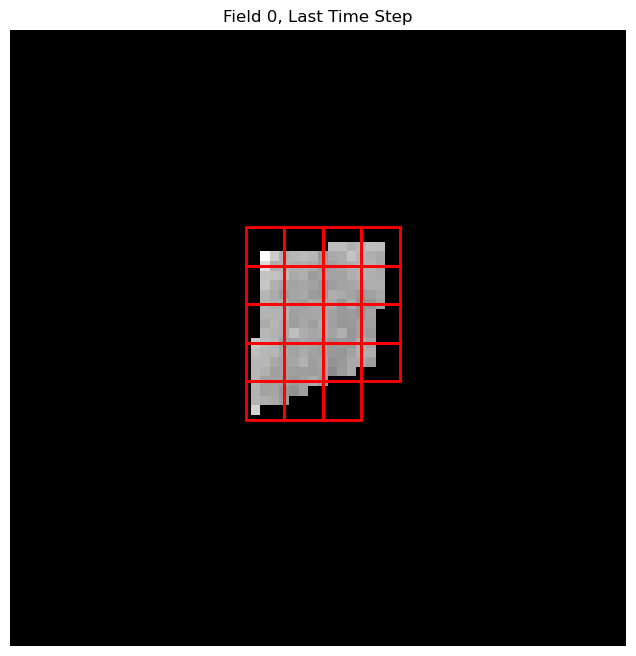

In [17]:
visualize_patches(image_tensor_test, field_numbers_test, test_patch_coordinates, 0, patch_size=4)

### Data Loaders - for Autoencoders

In [17]:
type(train_patches)

list

In [18]:
train_patches = torch.stack(train_patches)
test_patches = torch.stack(test_patches)
test_patches.shape

torch.Size([1197, 7, 3, 4, 4])

In [153]:
batch_size = 64
dataloader_train = create_data_loader(train_patches, train_patch_coordinates, batch_size=batch_size, shuffle=True)

for batch_inputs, batch_field_numbers in dataloader_train:
    print("Batch Inputs Shape:", batch_inputs.shape) 
    print("Batch Field Numbers:", batch_field_numbers)
    break  # Show one batch

Batch Inputs Shape: torch.Size([64, 6, 7, 4, 4])
Batch Field Numbers: [('1222250.0', '1187038.0_1187039.0', '1189784.0_1189788.0_1189793.0_1189795.0_1218453.0_1218735.0_1218738.0_1218750.0_1218753.0_1223918.0', '1169462.0_1225227.0', '1196255.0_1196256.0_1225775.0', '1168884.0_1220272.0_1220273.0_1220274.0', '1172758.0', '1223420.0', '1222819.0_1223600.0_1227573.0_1227681.0', '1180031.0_1195716.0', '1177692.0', '1194830.0_1225322.0', '1223522.0_1223526.0_1223533.0', '1222576.0', '1182884.0_1182885.0', '1223493.0', '1222370.0', '1177513.0', '1223197.0_1223199.0_1223204.0_1223208.0', '1217806.0_1227435.0_1227442.0', '1172244.0', '1179664.0_1179670.0_1179674.0', '1219909.0_1220103.0', '1177276.0_1177288.0', '1225908.0_1225914.0', '1191581.0_1224139.0_1224143.0', '1175448.0_1223570.0_1229484.0', '1175715.0', '1223324.0', '1223713.0', '1184053.0_1184055.0_1184057.0_1184062.0_1185908.0_1217084.0', '1222388.0', '1224233.0_1224234.0', '1168485.0_1184093.0', '1222630.0_1222635.0_1234669.0', '12

/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Master-Thesis-Github/Master-Thesis/Modeling/model_scripts/dataset_creation.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 2, 1, 3, 4)  # (N, T, C, H, W) -> (N, C, T, H, W)


In [154]:
batch_size = 64
dataloader_test = create_data_loader(test_patches, test_patch_coordinates, batch_size=batch_size, shuffle=False)

for batch_inputs, batch_field_numbers in dataloader_test:
    print("Batch Inputs Shape:", batch_inputs.shape) 
    print("Batch Field Numbers:", batch_field_numbers)
    break  # Show one batch

Batch Inputs Shape: torch.Size([64, 6, 7, 4, 4])
Batch Field Numbers: [('1168039.0', '1168039.0', '1168039.0', '1168039.0', '1168039.0', '1168039.0', '1168039.0', '1168039.0', '1168039.0', '1168039.0', '1168039.0', '1168039.0', '1168039.0', '1168039.0', '1168039.0', '1168039.0', '1168039.0', '1168039.0', '1168039.0', '1228889.0', '1228889.0', '1228889.0', '1228889.0', '1228889.0', '1228889.0', '1228889.0', '1228889.0', '1228889.0', '1228889.0', '1228889.0', '1228889.0', '1228889.0', '1228889.0', '1228889.0', '1228889.0', '1228889.0', '1228889.0', '1228889.0', '1168663.0_1176271.0', '1168663.0_1176271.0', '1168663.0_1176271.0', '1168663.0_1176271.0', '1168663.0_1176271.0', '1168663.0_1176271.0', '1168663.0_1176271.0', '1168663.0_1176271.0', '1168663.0_1176271.0', '1168663.0_1176271.0', '1168663.0_1176271.0', '1168663.0_1176271.0', '1168663.0_1176271.0', '1168692.0_1220431.0', '1168692.0_1220431.0', '1168692.0_1220431.0', '1168692.0_1220431.0', '1168692.0_1220431.0', '1168692.0_1220431.0

## Modeling: k-means

In [18]:
train_patches_tensor = torch.stack(train_patches)  # Convert to tensor [N, T, C, H, W]
test_patches_tensor = torch.stack(test_patches)

In [22]:
kmeans = train_kmeans_patches(train_patches_tensor, n_clusters=2, random_state=4)

train_patch_predictions = kmeans.predict(train_patches_tensor.reshape(train_patches_tensor.size(0), -1).numpy())
test_patch_predictions = kmeans.predict(test_patches_tensor.reshape(test_patches_tensor.size(0), -1).numpy())

# Assign field labels
threshold = 4
train_field_labels = assign_field_labels(train_patch_coordinates, train_patch_predictions, threshold)
test_field_labels = assign_field_labels(test_patch_coordinates, test_patch_predictions, threshold)

/Users/bhumikasadbhave007/tensorflow-test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [23]:
accuracy, report = evaluate_test_labels(test_field_labels, config.labels_path)
print(f"Test Accuracy: {accuracy}")
print(report)

Test Accuracy: 0.639344262295082
              precision    recall  f1-score   support

           0       0.70      0.27      0.39        26
           1       0.63      0.91      0.74        35

    accuracy                           0.64        61
   macro avg       0.66      0.59      0.57        61
weighted avg       0.66      0.64      0.59        61



In [89]:
# # Save train predictions to Excel
# save_train_predictions_to_excel(train_field_labels, "train_predictions.xlsx")

## Pre-trained Models